# Introduction to Dataset and Problem

Our dataset describes characteristics of basketball shots taken in NBA games in the 2014-2015 season. The data was scraped from the NBA rest API, and each entry in the dataset describes a single shot taken in a game. 

We are attempting to classify each shot as a made or missed shot using the attributes in the dataset. The data contains an attribute ('shot_result') we will be using as our label.

An accurate model would be able to tell us whether a shot with certain characteristics is likely to be made. A model like this would help inform NBA coaching staffs of the type of circumstances that generate likely shots. For instance, if a coach is wondering if a shot taken 10 feet from the basket with a defender 2 feet away is likely to be scored, they could use our model. Additionally, while we did not use the 'player_name' attribute in our modeling, it could be used by analytics teams to determine how their players fare in certain shooting situations. If a player makes most of his open 3 point shots but struggles to score layups at the basket, this could provide valuable information to NBA teams.

# Import libraries + dataset

In [2]:
import pandas as pd
import numpy as np
# import sklearn as sk
from datetime import timedelta
# from sklearn import model_selection, tree

In [53]:
filename = 'shot_logs.csv'
data = pd.read_csv(filename)
data = data.dropna() # SHOT_CLOCK originally has NaNs. I wonder why?
print(data.shape)

# Get rid of negative 'TOUCH_TIME' values
data = data.drop(data.index[data['TOUCH_TIME'] < 0])

data.head()

(122502, 21)


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
5,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,8:15,9.1,2,...,18.4,2,missed,"Williams, Deron",101114,2.6,0,0,brian roberts,203148


In [37]:
data.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.222030e+05,122203.000000,122203.000000,122203.000000,122203.000000,122203.000000,122203.000000,122203.000000,122203.000000,122203.000000,122203.000000,122203.000000,122203.000000,122203.000000
mean,2.140045e+07,0.253603,6.475717,2.471641,12.450301,1.994084,2.759785,13.449139,2.258652,159126.039713,4.122839,0.456495,1.006260,157321.372192
std,2.578359e+02,13.312980,4.681851,1.137948,5.756509,3.413942,2.935379,8.776124,0.437896,78685.768017,2.751535,0.498106,1.131276,79314.901366
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,200745.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.400000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.600000,2.000000,3.700000,22.400000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,37.000000,7.000000,24.000000,32.000000,24.900000,43.500000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


# Data Exploration

Because there were some NaN values in the dataset as well as negative values for the touch_time attribute (not possible to have the ball for a negative amount of time), we had to drop any entries with these characteristics before doing any kind of work on the data. 

There are 21 attributes in our dataset, both categorical and numerical. The 'pts', and 'fgm' features are redundant for us, because they are non-zero (in the case of 'pts') and increasing (in the case of 'fgm') for made shots and zero and non-inreasing otherwise, so they essentially describes the 'shot_result' attribute we chose to be our label.

Additionally, there are a number of features such as 'player_id', 'player_name', 'closest_defender_player_id', 'closest_defender', 'location', and 'matchup' that seem like they might be valuable (i.e. some defenders are better and the resulting shot likelihood would be lower), but not valuable enough to enhance the accuracy of our classifier.

There are also features that describe the context of the game the shot was taken in such as 'game_clock', 'period', 'final_margin', 'W', 'game_id', and 'shot_number' that are not pertinent to the specific shot we are trying to predict.

# Perform Feature Engineering

In [38]:
# fr https://stackoverflow.com/questions/50308629/python-pandas-column-convert-minutes-to-second
def timeToSeconds(x):
    mins, secs = map(float, x.split(':'))
    td = timedelta(minutes=mins, seconds=secs)
    return td.total_seconds()

In [39]:
# begin to separate the data into features and labels
labels = data['SHOT_RESULT'].map(dict(made=1, missed=0))

In [49]:
# Code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import time
import matplotlib.pyplot as plt

def plot_importance(features, labels):
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)

    forest = RandomForestClassifier()
    forest = forest.fit(x_train, y_train)

    start = time.time()
    result = permutation_importance(forest, x_test, y_test, n_repeats=10)
    print("Duration for forest importances:", time.time() - start)

    forest_importances = pd.Series(result.importances_mean, index=features.columns)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

Duration for forest importances: 24.1723690032959


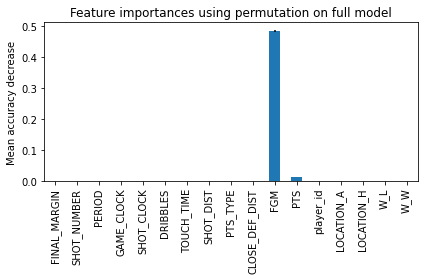

In [50]:
# Removed ID's and Game matchup string
features = data.drop(['SHOT_RESULT', 'GAME_ID', 'MATCHUP', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'player_name'], axis=1)
features['GAME_CLOCK'] = data['GAME_CLOCK'].apply(timeToSeconds)
features = pd.get_dummies(features)

plot_importance(features, labels)

Duration for forest importances: 27.79062581062317


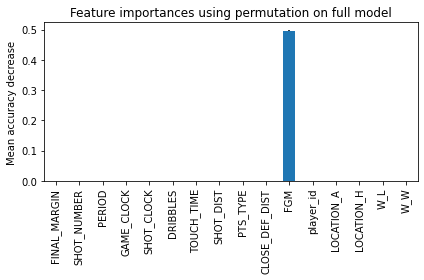

In [51]:
# Remove PTS, it looks completely correlated
features = data.drop(['PTS', 'SHOT_RESULT', 'GAME_ID', 'MATCHUP', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'player_name'], axis=1)
features['GAME_CLOCK'] = data['GAME_CLOCK'].apply(timeToSeconds)
features = pd.get_dummies(features)


plot_importance(features, labels)

Duration for forest importances: 119.80682444572449


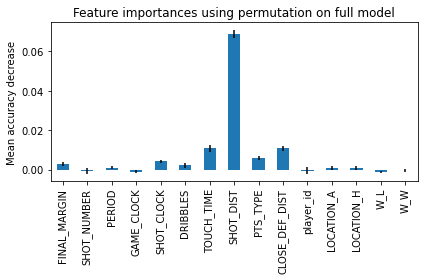

In [52]:
# Also remove FGM, it looks completely correlated
features = data.drop(['FGM', 'PTS', 'SHOT_RESULT', 'GAME_ID', 'MATCHUP', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'player_name'], axis=1)
features['GAME_CLOCK'] = data['GAME_CLOCK'].apply(timeToSeconds)
features = pd.get_dummies(features)


plot_importance(features, labels)

Our exploration of the data left us with six features that describe only the specific, relevant situation a shot was taken in:

1.    shot_clock: The amount of time remaining in a possession. It figures that if there is only a small amount of time left, a player might rush to get a shot off.

2.    touch_time: The amount of time the ball is in our specific shooter's posession. It seems that the longer the ball is in a player's possession, the less likely they are to score because they didn't have a clear shot when they recieved the ball.

3.    dribbles: The amount of dribbles the player takes before shooting. Dribbling a lot might mean the player did not have a clear shot when he recieved the ball, resulting in a less likely shot.

4.    pts_type: Whether the shot was a 2 or 3 point field goal. It figures that because 3-pointers are taken farther from the basket, they might be harder to score.

5.    shot_dist: How far from the basket the shot was taken. The closer a player is to the basket, the easier it is to score.

6.    close_def_dist: How far the closest defender is. The closer the nearest defender, the more contested and harder to make a shot becomes.

Upon looking more closely at the data, we decided to eliminate 'dribbles' and 'shot_type' from our final features list. Dribbles is a noisier version of 'touch_time' - a player can hold the ball for 10 seconds and either dribble it 10 times or 0 times, so this is not too helpful. We also realized that 'pts_type' is a less descriptive feature than 'shot_dist'. While pts_type might be useful for calculating the expected number of points for a shot, it does not tell us much about whether a shot will be made. A long 2 point shot has a very similar likelihood of being scored as a 3 point shot taken close to the line. 

In [42]:
# desired_features = ['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST']

In [43]:
desired_features = ['SHOT_CLOCK', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST']

In [44]:
# feature_data = data.drop(drop_features, axis=1)
feature_data = data.loc[:, desired_features]

# One hot encodes any remaining categorical variables (like Location or W)
feature_data = pd.get_dummies(feature_data)

feature_data.head()
feature_data.describe()

(122203, 4)
(122203, 4)


,SHOT_CLOCK,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST
count,122203.000000,122203.000000,122203.000000,122203.000000
mean,12.450301,2.759785,13.449139,4.122839
std,5.756509,2.935379,8.776124,2.751535
min,0.000000,0.000000,0.000000,0.000000
25%,8.200000,0.900000,4.700000,2.300000
50%,12.300000,1.600000,13.400000,3.700000
75%,16.600000,3.700000,22.400000,5.300000
max,24.000000,24.900000,43.500000,53.200000


# === Models ===

In [45]:
import sklearn as sk

# Tools
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Parallelism
from sklearn.utils import parallel_backend


## Decision Tree

In [46]:
# Essentially a playground for trying different parameters of decision trees
# These should probably be run with the cross validation of the cell below tbh, but these are just examples
train_features, test_features, train_labels, test_labels = sk.model_selection.train_test_split(feature_data, labels, test_size=0.20)

# use gini
classifier = DecisionTreeClassifier(criterion='gini')
classifier = classifier.fit(train_features, train_labels)
predictions = classifier.predict(test_features)
print('Accuracy on test data using Gini as split criterion is:', (sk.metrics.accuracy_score(test_labels, predictions)))
print()

# max depth
depth=4
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
classifier = classifier.fit(train_features, train_labels)
predictions = classifier.predict(test_features)
print('Accuracy on test data with max tree depth', depth, 'is:', (sk.metrics.accuracy_score(test_labels, predictions)))
print()

# minimum samples in a split set to 5
classifier = DecisionTreeClassifier(criterion='entropy', min_samples_split=5)
classifier = classifier.fit(train_features, train_labels)
predictions = classifier.predict(test_features)
print('Accuracy on test data with max tree minimum sample split 5 is:', (sk.metrics.accuracy_score(test_labels, predictions)))

Accuracy on test data using Gini as split criterion is: 0.5376212102614459

Accuracy on test data with max tree depth 4 is: 0.6138046724765762

Accuracy on test data with max tree minimum sample split 5 is: 0.5463360746286977


In [47]:
# Run cross validation with chosen hyperparameters

classifier = DecisionTreeClassifier(criterion='entropy', max_depth=10)
with parallel_backend('loky'):
    scores = cross_val_score(classifier, feature_data, labels, cv=5)
                                           
print("Average Accuracy:", scores.mean()*100)

Average Accuracy: 61.03450739551093


In [14]:
# Inner loop of nested cross validation - determine what are likely the best hyperparams

classifier = DecisionTreeClassifier()
params = {"max_depth": [5, 10, 15, 20],
          "min_samples_leaf": [5, 10, 15, 20],
          "max_features": [3, 4, 5, 6]}

grid_search = GridSearchCV(classifier, params, cv=5, scoring='accuracy')
with parallel_backend('loky'):
    grid_search.fit(feature_data, labels)

print(grid_search.best_params_)
print("Average Accuracy:", grid_search.best_score_*100)

{'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 10}
Average Accuracy: 61.434910228570416


In [15]:
# The Real Deal: Nested Cross Validation

with parallel_backend('loky'):
    scores = cross_val_score(grid_search, feature_data, labels, cv=10) 

print(grid_search.best_params_)
print("Average Accuracy:", scores.mean()*100)

{'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 10}
Average Accuracy: 61.446333110666515


## K Nearest Neighbors

Here we will explore the K nearest neighbors technique. This method is used to determine association based on the K nearest neighbors surrounding a data point. Based on this association, the prediction can be made based on classification of its neighbors.

In [13]:
scaler = sk.preprocessing.StandardScaler()
PCA = sk.decomposition.PCA()
knn = sk.neighbors.KNeighborsClassifier(n_neighbors=100)
pipe = Pipeline([('scaler' , scaler ), ('pca', PCA), ('knn', knn) ] )

with parallel_backend('loky'):
    accuracies = cross_val_score( pipe, feature_data, labels, cv=5)
    
print("Accuracies: ", accuracies.mean()*100)

Accuracies:  61.15817989936271


In [14]:
param_grid = {
    #'pca__n_components': list(range(5, 10)),
    'knn__n_neighbors': list(range(80, 120, 5))
}
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

with parallel_backend('loky'):
    gs.fit(feature_data, labels)

print(gs.best_params_)
print(gs.best_score_)

{'knn__n_neighbors': 110}
0.611753229564141


In [25]:
with parallel_backend('loky'):
    accuracies = cross_val_score( gs, feature_data, labels, cv=5)
print("Accuracies: ", accuracies.mean()*100)

Accuracies:  58.028437356576035


## Naive Bayes

In [26]:
# From the HW
classifier = GaussianNB()

# Cross validation accuracy
scores = cross_val_score(classifier, feature_data, labels, cv=10) 
print("Average Accuracy:", scores.mean()*100)

duration = 0.3098483085632324
Average Accuracy: 57.91334005220732


In [28]:
# Cross validation accuracy + other metrics
predictions = cross_val_predict(classifier, feature_data, labels, cv=10)

matrix = sk.metrics.confusion_matrix(labels, predictions)
report = sk.metrics.classification_report(labels, predictions)
print(report)

duration = 0.3035438060760498
              precision    recall  f1-score   support

           0       0.62      0.59      0.60     66622
           1       0.54      0.57      0.55     55880

    accuracy                           0.58    122502
   macro avg       0.58      0.58      0.58    122502
weighted avg       0.58      0.58      0.58    122502



## SVM

In [ ]:
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
svc = SVC()
pipeline = Pipeline(steps=[('scaler', scaler), ('PCA', pca), ('SVC', svc)])

param_grid = {
    'PCA__n_components': list(range(2, 4)),
    'SVC__kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)

with parallel_backend('loky'):
    predictions = cross_val_predict(grid_search, feature_data, labels, cv=10)

avg_accuracy = sk.metrics.accuracy_score(labels, predictions)
print("Average Accuracy:", avg_accuracy*100)
report = sk.metrics.classification_report(labels, predictions)
print(report)

## Neural Network

In [18]:
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
nn = MLPClassifier()
pipeline = Pipeline(steps=[('scaler', scaler), ('PCA', pca), ('NN', nn)])

param_grid = {
    'PCA__n_components': list(range(2, 6)),
    'NN__hidden_layer_sizes': [(8, ), (16, ), (32, ), (64, )],
    'NN__activation': ['logistic', 'tanh', 'relu']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
with parallel_backend('loky'):
    grid_search.fit(feature_data, labels)

print(grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

{'NN__activation': 'relu', 'NN__hidden_layer_sizes': (64,), 'PCA__n_components': 4}
0.6163409027036797


In [ ]:
with parallel_backend('loky'):
    predictions = cross_val_predict(grid_search, feature_data, labels, cv=5)

avg_accuracy = sk.metrics.accuracy_score(labels, predictions)
print("Average Accuracy:", avg_accuracy*100)
report = sk.metrics.classification_report(labels, predictions)
print(report)

## Random Forest

In [ ]:
classifier = RandomForestClassifier()

# Find the best hyperparamters for random forest
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [50, 100, 150, 200, 250, 300],
    'min_samples_split' : [2, 3, 4, 5, 6],
    'bootstrap' : [True, False]
}

# Train and test data
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

with parallel_backend('loky'):
    grid_search.fit(feature_data, labels)
    
# print best parameters
print(grid_search.best_params_)

with parallel_backend('loky'):
    predictions = cross_val_predict(grid_search, feature_data, labels, cv=5)

# print results
avg_accuracy = sk.metrics.accuracy_score(labels, predictions)
print("Average Accuracy:", avg_accuracy*100)
report = sk.metrics.classification_report(labels, predictions)
print(report)

# Final Thoughts and Conclusion

The highest accuracy we were able to acheive is around 61% with cross-validated decision trees and KNN as well as a trained neural network. 

Accuracies for each model are as follows:
Decision Tree with CV: 61.4% 
KNN with CV: 61.2%
Naive Bayes with CV:  57.9%
Neural Network: 61.6%

Our SVM and Random Forest models took too long to train (15+ minutes), and the results from training them without cross validation were not as accurate as other classification methods, so we decided to move on from those methods.

Classifying based on the most common label class (miss) would yield ~55% accuracy, so our model was a 6% improvement from a completely naive approach. While our classifier is not extremely accurate, it is still a useful way to understand the likelihood of scoring a shot. 

If we were to continue working on this project, we would likely look into more feature engineering to improve our models. One approach we considered was using 'player_name' in our models, as there are likely certain players better suited to making certain shots. Additionally, combining certain features into a single feature might also be useful. For instance, combining 'dribbles' and 'touch_time' might give us a more descriptive feature than each individually.  

It was interesting to work on a real-world dataset like this one. While we started with 21 columns in the CSV, only 4 proved to be useful. This goes to show that many data science projects depend more so on feature engineering and data cleaning than training models. 